In [2]:
import sys
import os
import math
from math import pi
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch
from scipy.signal import spectrogram


In [3]:
#Local best PSO minimizer
#Baseline (also default) PSO parameters
# def crcb_pso(fit_func_handle,n_dim,**kwargs):
#     pop_size=40
#     max_iter=2000
#     c1=1
#     c2=2
#     max_velocity=0.5
#     dc_law_a=0.9
#     dc_law_b=0.4
#     dc_law_c=0.2
#     bndry_cond=np.array([])
#     nbrhd_size=3
#     #add row and column seed
#     n_row_seed=0
#     n_col_seed=0
#     #Default for the level of information returned in the output
#     output_lvl=0
#     class Best:
#         def __init__(self,total_func_evals,best_loc,best_fitness):
#             self.total_func_evals=total_func_evals
#             self.best_loc=best_loc
#             self.best_fitness=best_fitness
#     retunr_data=Best([],np.zeros(n_dim),[])
    
#     #n_req_args=2
#     arg_eff=len(kwargs)
#     if len(kwargs)>0:
#         for name,value in kwargs.items():
#             if value is None:
#                 arg_eff-=1
#             else:
#                 if i==0:
                    
#                     #pso_par_field_names=args[i].keys()
#                     for i in range(0,len(pso_params)):
#                         fiedl_val=pso_params[i]#to be modified that pso_parames as a struct has the elements name,value.
                    


                

            


In [57]:
def crcbpso(fit_func_handle, n_dim, **kwargs):
    # Baseline (also default) PSO parameters
    pop_size = 40
    max_steps = 2000
    c1 = 2
    c2 = 2
    max_velocity = 0.5
    dc_law_a = 0.9
    dc_law_b = 0.4
    dc_law_d = 0.2
    boundary_cond = ''
    nbrhd_sz = 3
    output_lvl = 0
    n_row_seed=0
    n_col_seed=0
    
    return_data = {
        'total_func_evals': [],
        'best_location': np.zeros(n_dim),
        'best_fitness': []
    }
    # Override defaults if needed
    if 'pso_params' in kwargs:
        for key, value in kwargs['pso_params'].items():
            if value is not None:
                if key == 'pop_size':
                    pop_size = value
                elif key == 'max_steps':
                    max_steps = value
                elif key == 'c1':
                    c1 = value
                elif key == 'c2':
                    c2 = value
                elif key == 'max_velocity':
                    max_velocity = value
                elif key == 'start_inertia':
                    dc_law_a = value
                elif key == 'end_inertia':
                    dc_law_b = dc_law_a - value
                elif key == 'boundary_cond':
                    boundary_cond = value
                elif key == 'nbrhd_zs':
                    nbrhd_sz = value

    if 'output_lvl' in kwargs:
        output_lvl = kwargs['output_lvl']
        if output_lvl >= 1:
            return_data['all_best_fit'] = np.zeros(max_steps)

        if output_lvl >= 2:
            return_data['all_best_loc'] = np.zeros((max_steps,n_dim))
    # If seedMatrix is provided in kwargs, use it to initialize some particles
    if 'seed_matrix' in kwargs:
        seed_matrix = kwargs['seed_matrix']
        n_rows_seed, n_cols_seed = seed_matrix.shape
        if n_cols_seed > n_dim:
            raise ValueError("Too many coordinate parameters in seedMatrix")
        if n_rows_seed > pop_size:
            seed_matrix = seed_matrix[:pop_size, :]
            n_rows_seed, n_cols_seed = seed_matrix.shape
        
    

    # Initialization
    #Update constants involved in inertia decay 
    dc_law_c = max_steps
    dc_law_b = dc_law_a -dc_law_b
    #Number of left and right neighbors. Even neighborhood size is split asymmetrically: More right side neighbors than left side ones.
    nbrhd_sz = max([nbrhd_sz,3])
    left_nbrs = math.floor((nbrhd_sz-1)/2)
    right_nbrs = nbrhd_sz-1-left_nbrs
    
    #Information about each particle stored as a row of a matrix ('pop').
    #Specify which column stores what information.
    #(The fitness function for matched filtering is SNR, hence the use of 'snr'
    #below.)

    #pop = np.random.rand(popsize, n_dim)
    part_coord_cols = np.arange(0,n_dim) #Particle location
    part_vel_cols = np.arange(n_dim,2*n_dim)#Particle velocity
    part_p_best_cols = np.arange(2*n_dim,3*n_dim)#Particle pbest
    part_fit_pbest_cols = 3*n_dim+1#Fitness value at pbest
    part_fit_curr_cols = part_fit_pbest_cols+1#Fitness value at current iteration
    part_fit_lbest = part_fit_curr_cols+1#Fitness value at local best location
    part_inertia_cols = part_fit_lbest+1#Inertia weight
    part_local_best_cols = np.arange(part_inertia_cols,part_inertia_cols+n_dim)#Particles local best location
    part_flag_fit_eval_cols = part_local_best_cols[-1]+1#Flag whether fitness should be computed or not
    part_fit_evals_cols = part_flag_fit_eval_cols+1#Number of fitness evaluations
    n_cols_pop = len(part_coord_cols)+len(part_vel_cols)+len(part_p_best_cols)+1+1+1+1+len(part_local_best_cols)+1+1
    

    pop=np.zeros((pop_size,n_cols_pop))
    pop[:,part_coord_cols] = np.random.rand(pop_size,n_dim)
    if (n_row_seed>0)and(n_col_seed>0):
        pop[:n_rows_seed, :n_cols_seed] = seed_matrix
    
    velocities = (np.random.rand(pop_size, n_dim) - 0.5) * 2 * max_velocity
    # pbest = np.copy(pop)
    # pbest_fitness = np.full(popsize, np.inf)
    gbest_val = np.inf
    gbest_loc = 2*np.ones(n_dim)
    best_fitness=np.inf
    
    
    pop[:,part_vel_cols]= -pop[:,part_coord_cols]+np.random.rand(pop_size,n_dim)
    pop[:,part_p_best_cols]=pop[:,part_coord_cols]
    pop[:,part_fit_pbest_cols]= np.inf
    pop[:,part_fit_curr_cols]=0
    pop[:,part_fit_lbest]= np.inf
    pop[:,part_local_best_cols] = 0
    pop[:,part_flag_fit_eval_cols]=1
    pop[:,part_inertia_cols]=0
    pop[:,part_fit_evals_cols]=0

    # Start PSO iterations
    for lpc_steps in range(0,max_steps):
        # Evaluate particle fitnesses
        if boundary_cond!=None:
            fitness_values,_,_ = fit_func_handle(pop[:,part_coord_cols])
        else:
            fitness_values,_,pop[:,part_coord_cols] = fit_func_handle(pop[:,part_coord_cols])
        #Fill pop matrix
        for i in range(0,pop_size):
            pop[i,part_fit_curr_cols]=fitness_values[i]
            computeOK = pop[i,part_flag_fit_eval_cols]
            if computeOK:
                func_count = 1
            else:
                func_count = 0
            pop[i,part_fit_evals_cols]=pop[i,part_fit_evals_cols]+func_count
            if pop[i,part_fit_pbest_cols] > pop[i,part_fit_curr_cols]:
                pop[i,part_fit_pbest_cols] = pop[i,part_fit_curr_cols]
                pop[i,part_p_best_cols] = pop[i,part_coord_cols]

        
        # # Update pbest
        # update_mask = fitness_values < pbest_fitness
        # pbest[update_mask] = pop[update_mask]
        # pbest_fitness[update_mask] = fitness_values[update_mask]

        # Update gbest
        best_fitness=np.amin(pop[:,part_fit_curr_cols])
        best_particle = np.argmin(pop[:,part_fit_curr_cols])
        if best_fitness < gbest_val:
            gbest_val = best_fitness
            gbest_loc = pop[best_particle,part_coord_cols]
            pop[best_particle,part_fit_evals_cols]+=func_count
        #Update lbest
        for k in range(0,pop_size):
            ring_nbrs=np.append(np.arange(k-left_nbrs,k-1,1),k)
            ring_nbrs=np.append(ring_nbrs,np.arange(k+1,k+right_nbrs))
            adjust=ring_nbrs<0
            ring_nbrs[adjust]+=pop_size
            adjust=ring_nbrs>(pop_size-1)
            ring_nbrs[adjust]-=pop_size

            #Get local best in neighborhood
            lbest_part=np.argmin(pop[ring_nbrs,part_fit_curr_cols])
            lbest_tru_indx = ring_nbrs[lbest_part]
            lbest_curr_snr= pop[lbest_tru_indx,part_fit_curr_cols]     

            if lbest_curr_snr<pop[k,part_fit_curr_cols] :
                pop[k,part_fit_curr_cols]=lbest_curr_snr
                pop[k,part_local_best_cols]=pop[lbest_tru_indx,part_coord_cols]
        #inertia decay
        inertia_wt=max(dc_law_a-(dc_law_b/dc_law_c)*lpc_steps,dc_law_d)




        # Update velocities 
        for k in range(0,pop_size):
            pop[k,part_inertia_cols]=inertia_wt
            part_inertia=pop[k,part_inertia_cols]
            chi1=np.diag(np.random.rand(n_dim))
            chi2=np.diag(np.random.rand(n_dim))
            pop[k,part_vel_cols]=part_inertia*pop[k,part_vel_cols]+c1*(pop[k,part_p_best_cols]-pop[k,part_coord_cols])@chi1+c2*(pop[k,part_local_best_cols]-pop[k,part_coord_cols])@chi2
            
            maxv_bust_comp_pos = np.where(pop[k, part_vel_cols] > max_velocity)[0]
            maxv_bust_comp_neg = np.where(pop[k, part_vel_cols] < -max_velocity)[0]

            if maxv_bust_comp_pos.size > 0:
                pop[k, part_vel_cols[maxv_bust_comp_pos]] = max_velocity

            if maxv_bust_comp_neg.size > 0:
                pop[k, part_vel_cols[maxv_bust_comp_neg]] = -max_velocity

            pop[k,part_coord_cols]=pop[k,part_coord_cols]+pop[k,part_vel_cols]

            if np.any((pop[k, part_coord_cols] > 1) | (pop[k, part_coord_cols] < 0)):
                pop[k, part_fit_curr_cols] = np.inf
                pop[k, part_flag_fit_eval_cols] = 0
            else:
                pop[k, part_flag_fit_eval_cols] = 1

        for lpo in range(0,output_lvl):
            if lpo==0:
                return_data['all_best_fit'][lpc_steps]=gbest_val
            if lpo==1:
                return_data['all_best_loc'][lpc_steps,:]=gbest_loc
        
    actual_evaluations = sum(pop[:,part_fit_evals_cols])

    #Prepare main output
    return_data['total_func_evals'] = actual_evaluations
    return_data['best_location'] = gbest_loc
    return_data['best_fitness'] = gbest_val
    
    #Plot results
    # if n_dim==2:
    #     X,Y=np.meshgrid(
    #     fig,ax=plt.subplots(subplot_kw={"projection":"3d"})
    #     surf=ax.plot_surface(X,Y,Z,facecolors=plt.cm.viridis(np.abs(output)))
    
    #     plt.show()

    




    return return_data

# Example usage:
# fitfunc_handle = lambda x: ...  # Define your fitness function here
# result = crcbpso(fitfunc_handle, 5, pso_params={'popSize': 50, 'maxSteps': 1500})


In [49]:

def crcb_chk_std_srch_rng(x):
    if len(x.shape) == 1:
        n_row = 1
        n_col = x.shape[0]
        valid_pts=np.ones(n_row)
        for lp in range(0,n_row):
            x_temp=x[lp]
            if np.any((x_temp<0)|(x_temp>1)):
                valid_pts[lp]=0
    else:
        n_row, n_col = x.shape
        valid_pts=np.ones(n_row)
        for lp in range(0,n_row):
            x_temp=x[lp,:]
            if np.any((x_temp<0)|(x_temp>1)):
                valid_pts[lp]=0
    return np.array(valid_pts,dtype=bool)

def s2rv(x,params):
    n_row,n_col = x.shape
    r=np.zeros((n_row,n_col))
    r_min=params['r_min']
    r_max=params['r_max']
    rng=r_max-r_min
    for lp in range(0,n_row):
        r[lp,:]=x[lp,:]*rng+r_min
    return r

def r2sv(r,params):
    n_row,n_col = r.shape
    x=np.zeros((n_row,n_col))
    r_min=params['r_min']
    r_max=params['r_max']
    rng=r_max-r_min
    if np.array([rng]).shape[0]==1:
        if rng==0:
            rng=1
    else:
        rng[rng==0]=1
    for lp in range(0,n_row):
        x[lp,:]=(r[lp,:]-r_min)/rng
    return x





def crcbpso_test_func(x,params):
    if len(x.shape) == 1:
        x=x.reshape(1,-1)
        n_row = 1
        fit_val=np.zeros(n_row)
        valid_pts=np.ones(n_row)
        valid_pts=crcb_chk_std_srch_rng(x)
        fit_val[~valid_pts]=np.inf

        x[valid_pts]=s2rv(x[valid_pts],params)

        for lpc in range(0,n_row):
            if valid_pts[lpc]:
                x_temp=x[lpc]
                fit_val[lpc]=sum(x_temp*x_temp-10*np.cos(2*pi*x_temp)+10)
    else:
        n_row, _ = x.shape
    
        fit_val=np.zeros(n_row)
        valid_pts=np.ones(n_row)
        valid_pts=crcb_chk_std_srch_rng(x)
        fit_val[~valid_pts]=np.inf

        x[valid_pts,:]=s2rv(x[valid_pts,:],params)

        for lpc in range(0,n_row):
            if valid_pts[lpc]:
                x_temp=x[lpc,:]
                fit_val[lpc]=sum(x_temp*x_temp-10*np.cos(2*pi*x_temp)+10)
    return fit_val,x,r2sv(x,params)

print(np.array([[200,10]]).shape[0])

1


In [63]:
#Test crcbpso
ffparams = {
   'r_min':-100,
   'r_max':100 }
#Fitness function handle
fit_func_handle=lambda x: crcbpso_test_func(x,ffparams) 
#Call PSO
#np.random.seed(0)#Ensure that the random seed is correct
pso_out=crcbpso(fit_func_handle,2)
#Estimated parameters
std_coord=pso_out['best_location']
_,real_coord,_=fit_func_handle(std_coord)
print(f"Best location: {real_coord}")
print(f"Best fitness: {pso_out['best_fitness']}")



                  

Best location: [[-0.07808136  0.99268415]]
Best fitness: 2.181576562080563


In [51]:
#Call PSO with optional input parameters


20
(20, 10)
[15002.93124428]


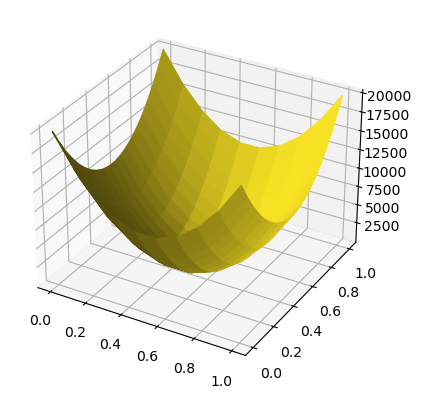

In [61]:
X,Y=np.meshgrid(np.linspace(0,1,10),np.linspace(0,1,20))
# print(crcbpso_test_func(X,ffparams))
print(X.shape[0])
Z=np.zeros((X.shape))
for i in range(0,X.shape[0]):
    seq=np.column_stack((X[i,:],Y[i,:]))
    val,_,_=crcbpso_test_func(seq,ffparams)
    Z[i,:]=np.array(val).reshape(1,-1)
print(np.array(Z).shape)
fig,ax=plt.subplots(subplot_kw={"projection":"3d"})
surf=ax.plot_surface(X,Y,Z,facecolors=plt.cm.viridis(np.abs(Z)))
val,_,_=crcbpso_test_func(np.array([0.03963041,0.09656414]),ffparams)
print(val)

In [ ]:
X,Y=np.meshgrid(np.linspace(0,1,10),np.linspace(0,1,10))
Z=crcbpso_test_func(X,)
fig,ax=plt.subplots(subplot_kw={"projection":"3d"})
surf=ax.plot_surface(X,Y,Z,facecolors=plt.cm.viridis(np.abs(output)))

plt.show()

[[10. 13. 16.]
 [16. 22. 25.]]
[[3 4 6 1 1 1]
 [3 4 5 6 7 9]]
[[3 4 6 3 1 1]
 [3 4 5 4 7 9]]


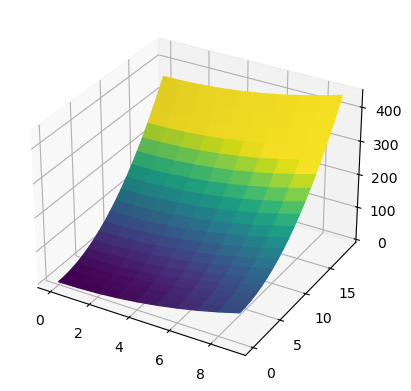

In [12]:
params={'r_max':10,
        'r_min':7

}
print(s2rv(np.array([[1,2,3],[3,5,6]]),params))
a=np.array([[3,4,6,0,0,1],[3,4,5,6,7,9]])
a[a==0]=1
print(a)
a[:,3]=np.array([3,4])
print(a)

X,Y=np.meshgrid(np.arange(0,10),np.arange(0,20))
Z=X*X+Y*Y

fig,ax=plt.subplots(subplot_kw={"projection":"3d"})
surf=ax.plot_surface(X,Y,Z,facecolors=plt.cm.viridis(np.abs(Z)))
    
plt.show()

In [120]:
a=np.array([2,3,1,4,5])
b=np.where(a<4)
print(b[0].size)
c,d=np.row_stack((a,a)).shape
print(c,d)
print(np.zeros(3)[2])


3
2 5
0.0


In [164]:
np.random.seed(0)
a=np.random.rand(10)
b=a
print(a)
print(np.diag(np.random.rand(1,10).reshape(1,-1)))
print(np.diag(np.array([1,3,4])),np.diag(a))
print(b@np.diag([np.random.rand(10)]))


[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152]
[0.79172504]
[[1 0 0]
 [0 3 0]
 [0 0 4]] [[0.5488135  0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.71518937 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.60276338 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.54488318 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.4236548  0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.64589411
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.43758721 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.891773   0.   

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 10)

In [124]:
a=np.zeros((3,10))
col=np.arange(1,5,1)
a[:,col]=np.array([[1,2,3,4],[5,6,7,8],[5,6,7,8]])
print(a)
print(np.append(a[1],5))
print(a[1][np.arange(1,5)])
print(np.argmax(a[:,4]))
print(a[:,4])
c,d=a.shape
print(c,d)
print(np.array([]).shape[0])

print(sum(a.reshape(-1,3)*a.reshape(-1,3)+10))

[[0. 1. 2. 3. 4. 0. 0. 0. 0. 0.]
 [0. 5. 6. 7. 8. 0. 0. 0. 0. 0.]
 [0. 5. 6. 7. 8. 0. 0. 0. 0. 0.]]
[0. 5. 6. 7. 8. 0. 0. 0. 0. 0. 5.]
[5. 6. 7. 8.]
1
[4. 8. 8.]
3 10
0
[234. 202. 242.]


In [99]:
b=np.arange(1,5)
a=b<0
print(b + (b>0)*4 + (b<0) *-4)
b[a]+=len(b)
a=b>(len(b)-1)
b[a]-=len(b)


[5 6 7 8]


In [104]:
def my_func(**kwargs):
    for name, value in kwargs.items():
        print(len(name))

class test:
    def __init__(self, name, value):
        self.name = name
        self.value = value

max_steps=10
pop_size=40
gbest_loc=100
gbest_val=1000

T= {
        'totalFuncEvals': max_steps * pop_size,
        'bestLocation': gbest_loc,
        'bestFitness': gbest_val
    }
S=test("a",10)
T['bestFitness']=10
T['bestLocation']=10
print(S,T['totalFuncEvals'],T)
            
    
my_func(arg1=T,b=None)

<__main__.test object at 0x7f4c472245d0> 400 {'totalFuncEvals': 400, 'bestLocation': 10, 'bestFitness': 10}
4
1
